<a href="https://colab.research.google.com/github/missu79/sa_for_friends_koreauniv_project/blob/main/2019516024_jungchangwoo_friends_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. 목적**
 - 본 파일은 고려대학교 디지털금융석사과정(계약과정) 중 <br>
   '디지털금융공학을 위한 자연언어 처리기술 과정'의 기말과제를 위해 만들어진 파일입니다.
   - 과제명 : Friends 감정분석기

- Dain Lee(ailohc)님의 소스를 전적으로 참고하였습니다.
  - 출처 : https://github.com/ailohc/friends-classification

- 주석(텍스트 편집)과 일부 코드 편집은 정창우 본인이 직접 하였음을 밝힙니다. <br>
  한줄한줄 공부하면서 진행했습니다.
  - missu797979@gmail.com

## **1. colab 연결**
 - 구글 드라이브를 colab의 /content/gdrive/ 에 연결
 - 암호 입력(인증)
 


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **2. transformer 설치**

In [4]:
!pip install transformers --quiet 

     |████████████████████████████████| 1.5MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 31.9MB/s 
     |████████████████████████████████| 890kB 55.9MB/s 


## **3. 필요한 라이브러리 가져오기**
 - NN, tokenizer 등 필요한 라이브러리 import

In [5]:
import torch
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import json
import os
import re
import pandas as pd
import numpy as np
import random
import time
import datetime

## **4. 경로 / max_len 지정**
 - train_path는 사용하지 않아 주석처리
 - 테스트 데이터는 케글에서 다운받은 en_data 파일 사용
 - 결과파일 저장명 지정
 - utterance의 max 값은 80으로 지정

In [6]:
#TRAIN_PATH = "friends_train.json"
TEST_PATH = "en_data.csv"

RESULT_PATH = "jcw"  
RESULT_TXT_PATH = RESULT_PATH + ".txt" 
RESULT_CSV_PATH = RESULT_PATH + ".csv"

MAX_LEN = 80  

## **5. 데이터 불러오기**
 - 학습데이터의 타입은 딕셔너리형으로 정의

 - 일반적으로 train / dev / test를 8:1:1 정도로 분리하는데, <br>
   <font color = "BLUE"> **- Dain Lee님의 필살 스킬 등장** <br>
     : 데이터양 확보를 위해 train+dev+test 모두 활용 </font> <br>
     <font color = "RED"> **[Tip1]** <br>
 데이터 양이 충분치 않다고 생각될 때는 가용가능한 모든 데이터를 사용하면 정확도 향상에 도움이 될 수도 있음<br>
 실제로 train data만을 가지고 돌렸을 때 보다 성능이 좋아짐 </font>


- 테스트 데이터 불러오기 (0 row는 인덱스라 스킵)

In [7]:
train_dic = {'label':[], 'utterance':[]}

for dtype in ['train', 'dev', 'test']:
  for dialog in json.loads(open('friends_' + dtype + '.json').read()):
    for line in dialog:
      train_dic['label'].append(line['emotion'])
      train_dic['utterance'].append(line['utterance'])

train = pd.DataFrame(train_dic)

test = pd.read_csv(TEST_PATH, usecols = [4], header=None,  skiprows = [0], names=['utterance'])

## **6. 버트 이용을 위한 전처리**
 - bert 수행하기 위해, 클래스 구분자 '[CLS]'와 문장 구분자 '[SEP]'을 사용

 - 감정의 레이블 데이터를 category형으로 지정
 - 매핑 : label을 str -> index(long)으로 변환

In [8]:
sentences = train['utterance'] 
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

train['label'] = train['label'].astype('category')

mapping = dict( enumerate(train['label'].cat.categories ) )

train['label'] = train['label'].cat.codes
labels = train['label'].values
labels = labels.astype('long')

## **7. 데이터 전처리**
 - RoBERTa 모델 활용하여 토큰화 진행 <br>
   - Large 모델 활용
   - 대소문자 구분 <br>
  <font color = "RED"> **[Tip2]** <br>
 Large 모델이 Base 모델보다 시간은 더 걸리지만, 정확도 향상에 도움이 됨<br>
 마찬가지로 대소문자 구분하지 않는 것(소문자화 = true)보다 구분하는 것(flase)가 약간이나마 향상 됨</font> 

- [RoBERTa] 에 대한 설명은 하기 링크 참조
  - https://brunch.co.kr/@choseunghyek/7
  - https://blog.naver.com/beneyh3000/222074120459

- 문장을 4번에서 지정했던 Max_len = 80 길이에 맞게 자르고, 모자란 부분은 0으로 채움

- Attnetion_mask를 패딩이 아니면 1, 패딩이면 0으로 설정함

- train_input 중 0.1(10%)를 랜덤으로 validation 데이터로 사용 <br>
  train_mask 또한 마찬가지

- 데이터를 tensor로 변환함
- 배치사이즈를 지정함 <br>
<font color = "RED"> **[Tip3]** <br>
 배치사이즈를 크게 하면 속도향상에는 도움이 되나, 메모리가 좋아야 가능함.
 256으로 돌려보니, runtime error가 발생하였음. 안전하게 32로 세팅</font>

- batch로 데이터셋을 가져오기 위해, 데이터셋을 생성함

- 상기와 유사하게 test-data에 대한 전처리도 진행

- GPU 사용



In [9]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels, 
                                                                                    random_state=2018, 
                                                                                    test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=2018, 
                                                       test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)	

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_sentences = test['utterance']
test_sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in test_sentences]

tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_masks = torch.tensor(attention_masks)

batch_size = 32

test_data = TensorDataset(test_inputs, test_masks)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=None)

if torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## **8. 모델링**
 - RoBERTa 모델 활용하여 진행, 감정은 8가지<br>
  <font color = "RED"> **[Tip4]** <br>
 최초에는 BERT-Large로 진행해봤으나, 정확도 향상에 한계가 존재 <br>
 RoBERTa 모델을 발견하고 돌리니, 정확도 크게 향상됨</font> 

 - optimizer로는 AdamW로 설정
 - [optimizer] 에 대한 설명은 하기 링크 참조
  - https://hiddenbeginner.github.io/deeplearning/2019/09/22/optimization_algorithms_in_deep_learning.html
  - Optimizer발전과정(그림 출처 : https://gomguard.tistory.com/187)
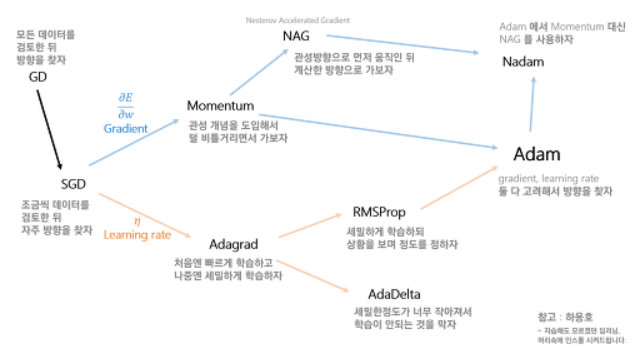


- 러닝레이트 설정하고, 0으로 나누는 것을 방지하기 위해 입실론 값 적용

- 에폭 횟수 설정

- 총 스텝은 배치반복 횟수 X 에폭

- 스케쥴러 생성(러닝레이트를 조금씩 변화시킴)

<font color = "RED"> **[Tip5]** <br>
 learning rate와 epoch을 조정하여 여러번 돌려볼 필요가 있음</font> 

- 정확도 계산 함수를 정의
  - 보통 accuracy, recall, f1 score 등을 사용하나, 여기서는 산술평균을 사용했음

- 소요시간 측정을 위한 함수를 정의

- 재현을 위해 랜덤시드 고정

- 그래디언트 초기화

In [10]:
model = RobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=8)
model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-6,
                  eps = 1e-8
                )
epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

seed_val = 27
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model.zero_grad()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

## **9. 학습 및 검증**
- 에폭만큼 학습 수행

#ㅁ training#
  - 트레인 모델
  - 데이터로더에서 batch만큼 반복하여 가져옴
  - batch를 GPU에 넣음
  - batch에서 데이터 추출
  - forward 수행
  - loss 및 총 loss 계산
  - backward 수행
  - gradient 클리핑
  - 가중치 parameter 업데이트
  - 스케쥴러로 러닝레이트 감소
  - gradient 초기화
  - 평균 loss 구하기

#ㅁ validation#
  - 평가 모델
  - 데이터로더에서 batch만큼 반복하여 가져옴
  - batch를 GPU에 넣음
  - batch에서 데이터 추출
  - gradient 계산 안함
  - loss 구하기
  - cpu로 데이터 이동
  - 출력 로짓과 라벨을 비교하여 정확도 계산

In [11]:
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0

    model.train()
 
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)  
        b_input_ids, b_input_mask, b_labels = batch 

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        loss = outputs[0] 
        total_loss += loss.item() 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step() 
        scheduler.step() 
        model.zero_grad() 
  
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch) 
        b_input_ids, b_input_mask, b_labels = batch 
        
        with torch.no_grad():  
   
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        pred_label = np.argmax(logits, axis=1).flatten()
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 2 ========
Training...

  Average training loss: 1.47
  Training epcoh took: 0:09:42

Running Validation...
  Accuracy: 0.6102
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...

  Average training loss: 1.16
  Training epcoh took: 0:09:46

Running Validation...
  Accuracy: 0.6285
  Validation took: 0:00:22

Training complete!


## **10. 최종 제출데이타에 대한 예측 수행**

- 결과를 쓸 파일 열기
  - batch를 GPU에 넣음
  - batch에서 데이터 추출
  - gradient 업데이트 하지 않음
  - 결과예측
  - 감정평가

- csv 파일 만들어 dataframe에있는 데이터를 기록
- 최종 제출 파일 생성

In [13]:
t0 = time.time()

model.eval()

with open(RESULT_TXT_PATH, "a") as f:
  for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch) 
    b_input_ids, b_input_mask = batch 

    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    
    for logit in logits:
      label = np.argmax(logit)
      f.write(mapping[label] + '\n')

result = pd.read_csv(RESULT_TXT_PATH, delimiter='\t', names=['Expected'])
result.index.name='Id'
result.to_csv(RESULT_CSV_PATH, index=True, header=True)